In [18]:
import os
import re
from datetime import timedelta
from time import time

import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
import spacy
import warnings
warnings.filterwarnings('ignore')
from spacy import displacy
nlp = spacy.load("en_ner_bionlp13cg_md")
import numpy as np
sns.set(style="darkgrid")

data_analysis_path = '../results/data_analysis/'

In [3]:
df = pd.read_excel('../data/Questions.xlsx')
type_to_category = {'summary': 0, 'list': 1, 'yesno': 2, 'factoid': 3}

apply_type_to_category = lambda t: type_to_category[t]

df['category_id'] = df['Type'].apply(apply_type_to_category)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(df['Question'], df['category_id'],
                                                                                 df.index,
                                                                                 test_size=0.2, random_state=0)

In [3]:
X_train.shape, X_test.shape

((1800,), (451,))

In [10]:
def display_NER(s):
    doc = nlp(s)
    displacy.render(doc, style="ent",jupyter=True)

    
for s in X_train[6:10]:
    display_NER(s)

In [27]:
from collections import Counter

def plot_countplot(dataframe, target_column, dataset_name):
    number_of_classes = len(Counter(dataframe[target_column]))
    x_size = number_of_classes + 1
    y_size = 4
    plt.figure(figsize=(x_size, y_size))
    sns.countplot(x=target_column, data=dataframe)
    plt.savefig(data_analysis_path + 'distribution_' + dataset_name, bbox_inches='tight', dpi=200)
    plt.show()

In [11]:
whole_quora = pd.read_csv('../data/whole_quora.csv', index_col=0)
whole_quora.isnull().sum()
whole_quora= whole_quora.dropna()

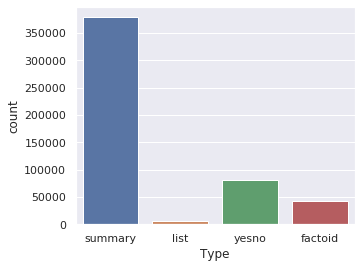

In [28]:
plot_countplot(whole_quora,'Type','whole_quora')

In [17]:
whole_quora.shape

(509089, 4)

In [18]:
filtered_quora = pd.read_csv('../data/filtered_quora.csv', index_col=0)
filtered_quora.shape

(176325, 4)

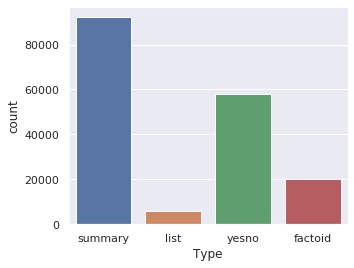

In [29]:
plot_countplot(filtered_quora,'Type','filtered_quora')

In [41]:
def parse_line(line):
    splitted = line.strip().split()
    class_name = splitted[0]
    class_f_score = splitted[3]
    return class_name, class_f_score
    
def parse_from_model_string(model_results):
    splitted = model_results.split('\n')
    # print(model_results)
    model_name = splitted[0]
    f_scores = {}
    for indx in range(3,7):
        name, f_score = parse_line(splitted[indx]) 
        f_scores[name] =f_score 
    model_training_time = splitted[-1].split()[-1]
    model_accuracy = splitted[-5].split()[-2]
    summary = {'Model':model_name,'Training Time:': model_training_time,'Accuracy': model_accuracy, 'Scores:': f_scores}
#     print(summary)
    return [model_name, model_training_time, model_accuracy, list(f_scores.values())]
    
def make_results_table(results_path):
    with open(results_path, 'r') as f:
        st = f.read()
        results_by_model = st.strip().split('--------------------------------------------------------------------------------')
        model_names = []
        model_times = []
        model_accuracies = []
        model_f_scores = []
        for model in results_by_model[:-1]:
            model_name, model_training_time, model_accuracy, f_scores = parse_from_model_string(model.strip())
            model_names.append(model_name)
            model_times.append(model_training_time)
            model_accuracies.append(model_accuracy)
            model_f_scores.append(f_scores)
        results = pd.DataFrame(index=['summary F-score','list F-score','yesno F-score','factoid F-score','Accuracy', 'Training Time'], columns=model_names)
    results.loc['Accuracy',:] = [float(a) for a in model_accuracies]
    results.loc['Training Time',:] = model_times

    for i,col in enumerate(results.columns):
        results.loc[['summary F-score','list F-score','yesno F-score','factoid F-score'],col] =  model_f_scores[i]

#     print(results.to_latex())    
    return results.loc['Accuracy',:].values, results.columns

for experiment_folder in ['../results/t2_experiments/']:

    for experiment in os.listdir(experiment_folder):
        path = os.path.join(experiment_folder, experiment)
        if '.txt' in experiment:
            accuracies, col = make_results_table(path)
            print(np.max(accuracies), np.min(accuracies), np.mean(accuracies), path)
# 

0.79 0.69 0.76 ../results/t2_experiments/quora_base_balanced_preprocessing.txt
0.81 0.47 0.745 ../results/t2_experiments/whole_quora.txt
0.85 0.61 0.8033333333333333 ../results/t2_experiments/filtered_quora.txt
0.79 0.61 0.7466666666666667 ../results/t2_experiments/whole_quora_preprocessing.txt
0.79 0.69 0.7666666666666666 ../results/t2_experiments/filtered_quora_preprocessing.txt


In [46]:
range(5)

range(0, 5)

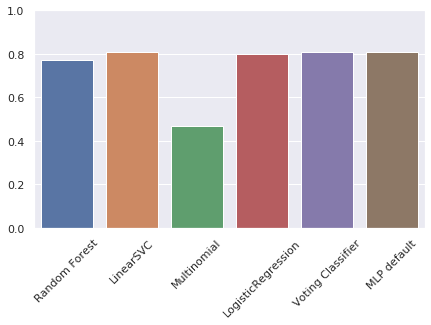

In [57]:
def plot_the_results(accuracies):
    models = ['Random Forest', 'LinearSVC', 'Multinomial', 'LogisticRegression',
       'Voting Classifier', 'MLP default']
    number_of_classes = len(models)
    x_size = number_of_classes + 1
    y_size = 4
    plt.figure(figsize=(x_size, y_size))
    sns.barplot(x=models, y=accuracies)
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

    plt.savefig('whole_quora_best_results', bbox_inches='tight', dpi=200)
    plt.show()
plot_the_results(quora_accuracies)

In [36]:
best_base = '../results/t1_experiments/baseline_preprocessing.txt'
best_quora_filtered = '../results/t2_experiments/filtered_quora.txt'
best_quora = '../results/t2_experiments/whole_quora.txt'

base_accuracies = make_results_table(best_base)
filtered_accuracies = make_results_table(best_quora_filtered)
quora_accuracies = make_results_table(best_quora)